# CS470 Introduction to Artificial Intelligence
## Deep Learning Practice 
#### TA. Minho Sim
---

### Agenda for today
#### 2-1. MLP-based Classification
#### 2-2. Text classification using IMDB dataset
#### 2-3. Overfitting and how to fight it
#### 2-4. Save and restore models
---
<br/>
<br/>
<br/>


## 2-1. MLP-based Classification

#### Topics for this chapter
 * MNIST datset
 * Build/Compile/Train the model
 * Hyperparameter
 * Plot metrics
 * Evaluate/Test test data
 * Visualize the results
---

### Image classification using MNIST dataset

In this practice, we will build our first fully connected feed-forward network. 
We will construct a neural network consisting of two fully connected layers and apply this model to the digit classification task. 
Our network will ultimately output **a probability distribution over the 10 digit classes (0-9)**. 
The architecture of the network we are going to build is depicted below:

![Architecture - MNIST](https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/architecture-mnist.png?raw=true)

#### MNIST dataset

The [MNIST dataset](http://yann.lecun.com/exdb/mnist) is a large database of handwritten digits that is commonly used for training various image processing systems. This dataset consists of 60,000 training images and 10,000 test images. The target classes for this dataset are the digits (0-9). 

Let's download and load the dataset and display a few random samples from it. We can load them by mnist module in keras.datasets.

In [48]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print('Tensorflow: ', tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

Tensorflow:  2.6.0


In [49]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)

train_images = np.expand_dims(train_images, axis=-1) / 255
print(train_images.shape)

train_labels = np.int64(train_labels)
test_images = np.expand_dims(test_images, axis=-1) / 255
test_labels = np.int64(test_labels)
class_names = ['0','1','2','3','4','5','6','7','8','9']

(60000, 28, 28)
(60000, 28, 28, 1)


Our training set is made up of 28x28 grayscale images of handwritten digits. Let's visualize some of these images and check their corresponding training labels.

By using the written codes below, we can check randomly sampled 36 images and their corresponding labels.

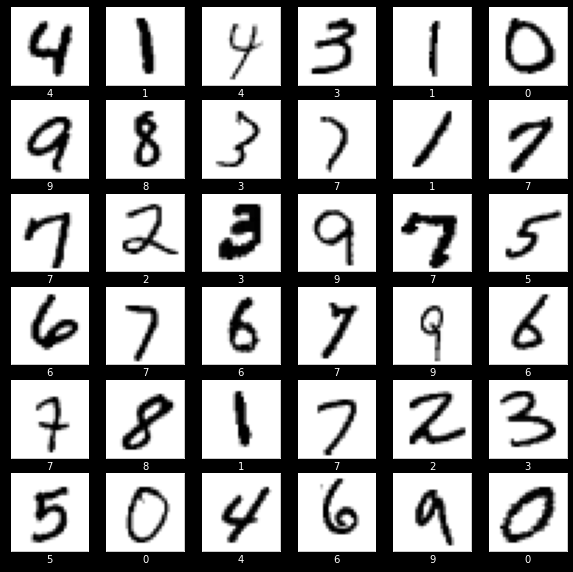

In [50]:
plt.figure(figsize=(10, 10))
random_indicies = np.random.choice(60000, 36)

for index in range(36):
    plt.subplot(6, 6, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_index = random_indicies[index]
    plt.imshow(np.squeeze(train_images[image_index]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_index])

#### Build model

To construct the architecture of the fully connected neural network, we'll once again use the Keras API and define the model using the [`tf.keras.Sequential`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Sequential) class. Note that we first use a [`tf.keras.layers.Flattern`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Flatten) layer, which flattens the input so that the flatten vector can be fed into the model. 

In [51]:
# TODO: define a sequential model
model = tf.keras.Sequential([
    # TODO: add a flatten layer
    tf.keras.layers.Flatten(input_shape=train_images.shape[1:]),
    # TODO: add the first dense layer with 128 nodes applying ReLU activation function
    tf.keras.layers.Dense(128, activation=tf.nn.relu)
    # TODO: add the last dense layer with 10 (the number of digits) nodes applying Softmax activation function
    
])

![Flatten](https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/flatten.png?raw=true)

Let's take a step back and think about the network we've just made. The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a 2d-array (28 x 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. You can think of this layer as unstacking rows of pixels in the image and lining them up. There are no trainable parameters in this layer and it only reshapes the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are fully connected neural network layers. 
Each dense layer has following activation function.

- The second `Dense` layer has 128 nodes (or neurons)
    - ReLU $ f(x) = \max(0, x) $ activation function is applied to an output of this layer.
        - This introduces **non-linearity** in the input space.
        - By this non-linearity, the network can learn to capture complicated (linearly non-separable) relationships.
- The last `Dense` layer has 10 nodes (or neurons)
    - Softmax $ f_j(z) = \frac{e^{z_j}}{\sum_{K} e^{z_k}} $ activation function is applied to an output of this layer.
        - This takes a vector of arbitrary real-valued scores and squashes it to **a vector of values between zero and one that sum to one**, which can be interpreted as probability.
        - That vector can represent a probability distribution over predicted output classes given the input value.
        

<br/>
<img src="https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/softmax.jpeg?raw=true" width=500>
<br/>


By calling `summary()`, we can check the models architecture briefly.

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
Total params: 100,480
Trainable params: 100,480
Non-trainable params: 0
_________________________________________________________________


_Wait! Can you derive the number of parameters of each layer?_

#### Compile the model

Before training the model, we need to define a few more settings. These settings will be applied during the model's [`compile`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) step:

- *Loss function*: This defines a measure of how accurate our model is. During training, we want to minimize this function, which will "steer" the model in the right direction.
- *Optimizer*: This defines how the model is updated based on the data it sees and its loss function.
- *Metrics*: Here we can define metrics used to monitor the training and testing steps.

We'll start out by using _adam_ optimizer initialized with a learning rate of 0.001. Since we are performing a categorical classification task, we will use the [sparse_categorical_crossentropy](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy).

You can experiment with other the choice of optimizer and learning rate and then evaluate how these affect the accuracy of the model. 

In [53]:
# TODO: compile the model with the following parameters
# - Optimizer: adam optimizer
# - Loss: sparse_categorical_crossentropy 
# - Metrics: accuracy

model.compile(
    
####
  optimizer = 'adam',
  loss = 'sparse_categorical_crossentropy',
  metrics = ['accuracy']

    
####
    
)

#### Train the model

We're now ready to train our model. Now we will feed the training data `(train_images, train_labels)` into the model, and then ask it to learn the associations and relationships between images and labels. We'll also need to define the batch size, the number of epochs or iterations (some hyperparameters) over the MNIST dataset to specify the training. After specifying the model settings with the Keras API in the `compile` step, training can be started by calling the [`fit`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit) method on an instance of the `Model` class. 

#### Hyperparameter
In machine learning, hyperparameters are parameters with values that are used to control the learning process. In contrast to the parameters within the model, the values of hyperparameters are not trainable. Number of layers and size of model can be also considered as hyperparameters. By changing hyperparameters and monitoring the metrics, we can choose proper hyperparameters.

In [54]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 64
EPOCHS = 10

In [61]:
# TODO: train the model using (train_images, train_labels). 
#       do not forget to set epochs and batch size as the parameters!

network_history = model.fit(
    
####
    train_images,
    train_labels,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE
    
    
####
    
)

Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 3.7313 - accuracy: 0.3340
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 3.8163 - accuracy: 0.3162
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 3.6083 - accuracy: 0.3669
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 3.5503 - accuracy: 0.3756
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 3.6067 - accuracy: 0.3609
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 3.6255 - accuracy: 0.3559
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 3.7257 - accuracy: 0.3334
Epoch 8/10
938/938 [==============================] - 2s 2ms/step - loss: 3.7094 - accuracy: 0.3363
Epoch 9/10
938/938 [==============================] - 2s 2ms/step - loss: 3.7833 - accuracy: 0.3203
Epoch 10/10
938/938 [==============================] - 2s 2ms/step - loss: 3.6997 - accuracy: 0.3377

As the model trains, the loss and accuracy metrics are displayed. With ten epochs and a learning rate of 0.01, this fully connected model achieved an accuracy of approximatley 0.98 (or 98%) on the training data.

#### Plotting network performance trend

The return value of the `fit` function is a `tf.keras.callbacks.History` object which contains the entire history of training/validation loss and accuracy, for each epoch. We can therefore plot the trend of loss and accuracy of our model during the training phase.

In [56]:
history_dict = network_history.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

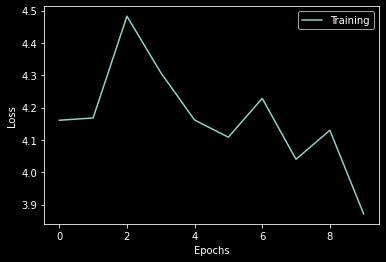

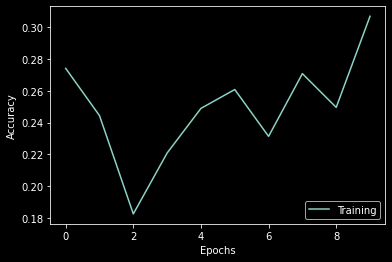

In [57]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.legend(['Training'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

#### Evaluate accuracy on the test dataset

Now we've trained the model and we can use the trained model to make predictions about test dataset which hasn't seen before to the model. In our practice, the `test_images` array comprises our test dataset. To evaluate accuracy, we can check whether the model's predictions match with the ground truth labels from the `test_labels` array. 

We will use the [`evaluate`](https://tensorflow.google.cn/api_docs/python/tf/keras/models/Sequential#evaluate) method to evaluate the model on the test dataset.

In [58]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print('Test accuracy:', test_accuracy)

313/313 - 0s - loss: 3.7031 - accuracy: 0.3413
Test accuracy: 0.34130001068115234


You may observe that the accuracy on the test dataset is a little lower than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*, which occurs when a trained model performs worse on new (test) data than on its training data (we will talk about _overfitting_ in the next practice).

#### Make predictions
With the trained model, let's observe some predictions about in the test images.

In [59]:
predictions = model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction output of the model.

[0.        0.        0.        0.        0.        0.        0.
 1.3687358 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.       

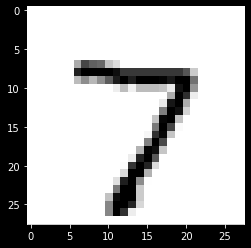

In [60]:
print(predictions[0])
plt.imshow(np.squeeze(test_images[0]), cmap=plt.cm.binary)

Each decimal number in the array represents the confidence level of the model's prediction.

This time, let's check which number the model has predicted by looking at the image.

In [62]:
print('Predicted digit for test image[0]: {}'.format(np.argmax(predictions[0])))

Predicted digit for test image[0]: 7


So, the model is most confident that this image is a "7". We can check the test label (remember, this is the true identity of the digit) to see if this prediction is correct:

In [63]:
print('Ground truth of test image[0]: {}'.format(test_labels[0]))

Ground truth of test image[0]: 7


#### Visualize classification results
We can define a couple of functions to visualize the classification results on the MNIST dataset with our model. First, we'll write a function, `plot_image`, to plot images along with their predicted label and the probability of the prediction. Second, we'll also define a function, `plot_value_array`, to plot the prediction probabilities for each of the digits. 

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(np.squeeze(img), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

Let's use these functions to visualize the model's predictions for the images in the test dataset: 

In [ ]:
i = 8 
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

We can also plot several images along with their predictions, where correct prediction labels are blue and wrong prediction labels are red. The number below the image gives the degree of confidence for the predicted label. Note the model may be very confident in an incorrect prediction.

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

This time, let's check how the mispredicted images look like.

In [ ]:
wrong_prediction=[]
for i in range(1000):
    if np.argmax(predictions[i]) != test_labels[i]:
        wrong_prediction.append(i)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(wrong_prediction[i], predictions[wrong_prediction[i]], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(wrong_prediction[i], predictions[wrong_prediction[i]], test_labels)
plt.tight_layout()
plt.show()

Some images are difficult to distinguish even for human-beings. Through this, we can learn that in order to get high model performance, the quality of the dataset to be used for the training must be well managed.